<a href="https://colab.research.google.com/github/MarielaNina/NeuralNetworksClass/blob/main/Projeto3_Mariela_Nina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJETO 3: VARIATIONAL AUTOENCODERS (VAE)

**Autor:** Mariela Nina

**Disciplina:** Redes Neurais

**Professor:** Marcos G. Quiles  

**Data:** Noviembre 2025


# 1) Importação de Bibliotecas

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')


# 2) Configuração Global

In [2]:
# Hiperparâmetros do modelo
LATENT_DIM = 12          # Dimensão do espaço latente
EPOCHS = 50              # Número de épocas de treinamento
BATCH_SIZE = 128         # Tamanho do batch
VALIDATION_SPLIT = 0.15  # 15% de dados para validação

print("HIPERPARÂMETROS DO MODELO:")
print(f"• Dimensão do espaço latente: {LATENT_DIM}")
print(f"• Número de épocas: {EPOCHS}")
print(f"• Tamanho do batch: {BATCH_SIZE}")
print(f"• Split de validação: {VALIDATION_SPLIT*100:.0f}%")

HIPERPARÂMETROS DO MODELO:
• Dimensão do espaço latente: 12
• Número de épocas: 50
• Tamanho do batch: 128
• Split de validação: 15%


# 3) Arquitetura do VAE

**3.1 Função de Sampling (Reparameterization Trick)**


In [3]:
print("\n NOTA:")
print("   Esta é a chave do VAE! Em vez de amostrar diretamente de uma")
print("   distribuição (o que não é diferenciável), usamos o trick:")
print("   ")
print("   z = μ + σ * ε, onde ε ~ N(0,1)")
print("   ")
print("   Isso permite backpropagation através da operação de amostragem.\n")

def sampling(args):
    """
    Implementa o reparameterization trick para VAE.

    Baseado no código de referência fornecido pelo professor.

    Parâmetros:
    -----------
    args : tuple
        (z_mean, z_log_var) - média e log-variância da distribuição latente

    Retorna:
    --------
    z : tensor
        Amostra do espaço latente
    """
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]

    # Amostrar epsilon de distribuição normal padrão
    epsilon = tf.random.normal(shape=(batch, dim))

    # Reparameterization trick: z = μ + σ * ε
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon



 NOTA:
   Esta é a chave do VAE! Em vez de amostrar diretamente de uma
   distribuição (o que não é diferenciável), usamos o trick:
   
   z = μ + σ * ε, onde ε ~ N(0,1)
   
   Isso permite backpropagation através da operação de amostragem.



**3.2 Construção do Encoder e Decoder**


In [4]:
print("\n ARQUITETURA:")
print("   ENCODER: Conv2D → Conv2D → Flatten → Dense → (μ, σ) → Sampling")
print("   DECODER: Dense → Reshape → Conv2DTranspose → Conv2DTranspose → Saída\n")

def build_vae(input_shape=(28, 28, 1), latent_dim=12):
    """
    Constrói o Encoder e Decoder do VAE com camadas convolucionais.

    Arquitetura baseada no modelo de referência do professor com melhorias.

    Parâmetros:
    -----------
    input_shape : tuple
        Forma da entrada (28, 28, 1) para imagens em escala de cinza
    latent_dim : int
        Dimensão do espaço latente

    Retorna:
    --------
    encoder, decoder : keras.Model
        Modelos do encoder e decoder
    """

    # ===== ENCODER =====
    # Mapeia a imagem para uma distribuição no espaço latente
    encoder_inputs = keras.Input(shape=input_shape, name='encoder_input')

    # Camadas convolucionais para extração de features
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding='same',
                      name='conv1')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding='same',
                      name='conv2')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(128, activation='relu', name='dense_intermediate')(x)

    # Camadas de saída: média e log-variância
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    # Camada de amostragem (reparameterization trick)
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Modelo encoder completo
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

    # ===== DECODER =====
    # Reconstrói a imagem a partir do espaço latente
    latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')

    # Expandir dimensões
    x = layers.Dense(7 * 7 * 64, activation='relu', name='dense_decoder')(latent_inputs)
    x = layers.Reshape((7, 7, 64), name='reshape')(x)

    # Camadas de deconvolução (transposed convolution)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same',
                               name='deconv1')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same',
                               name='deconv2')(x)

    # Camada de saída: reconstrução da imagem
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same',
                                            name='decoder_output')(x)

    # Modelo decoder completo
    decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

    return encoder, decoder



 ARQUITETURA:
   ENCODER: Conv2D → Conv2D → Flatten → Dense → (μ, σ) → Sampling
   DECODER: Dense → Reshape → Conv2DTranspose → Conv2DTranspose → Saída



**3.3 Classe VAE Personalizada**


In [5]:
print("\nIMPLEMENTAÇÃO:")
print("• Combina Encoder e Decoder")
print("• Implementa loss personalizado: Reconstruction + KL Divergence")
print("• Permite tracking de métricas durante treinamento\n")

class VAE(keras.Model):
    """
    Classe VAE que combina Encoder e Decoder.

    Implementa a função de loss personalizada conforme especificação:
    Loss = Reconstruction Loss + KL Divergence
    """

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        # Métricas para tracking
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """Retorna as métricas que serão rastreadas durante o treinamento"""
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """
        Passo de treinamento personalizado.
        Calcula reconstruction loss + KL divergence.
        """
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # 1. Reconstruction loss (Binary Crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # 2. KL Divergence loss
            # KL(N(μ,σ) || N(0,1)) = -0.5 * Σ(1 + log(σ²) - μ² - σ²)
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            # 3. Total loss
            total_loss = reconstruction_loss + kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Atualizar métricas
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """
        Passo de avaliação (validação/test).
        Similar ao train_step mas sem atualizar pesos.
        """
        if isinstance(data, tuple):
            data = data[0]

        # Forward pass (sem gradientes)
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Calcular losses
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


IMPLEMENTAÇÃO:
• Combina Encoder e Decoder
• Implementa loss personalizado: Reconstruction + KL Divergence
• Permite tracking de métricas durante treinamento



#4) Funções de Visualização


**4.1) visualização do histórico de treinamento**


In [6]:
def plot_training_history(history, dataset_name):
    """
    Plota a evolução das losses durante o treinamento.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss total
    axes[0].plot(history.history['loss'], label='Treino', linewidth=2, color='#2E86AB')
    axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2,
                 color='#A23B72', linestyle='--')
    axes[0].set_title(f'{dataset_name}\nLoss Total', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Época', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Reconstruction loss
    axes[1].plot(history.history['reconstruction_loss'], label='Treino',
                 linewidth=2, color='#2E86AB')
    axes[1].plot(history.history['val_reconstruction_loss'], label='Validação',
                 linewidth=2, color='#A23B72', linestyle='--')
    axes[1].set_title(f'{dataset_name}\nReconstruction Loss', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Época', fontsize=11)
    axes[1].set_ylabel('Loss', fontsize=11)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    # KL Divergence loss
    axes[2].plot(history.history['kl_loss'], label='Treino',
                 linewidth=2, color='#2E86AB')
    axes[2].plot(history.history['val_kl_loss'], label='Validação',
                 linewidth=2, color='#A23B72', linestyle='--')
    axes[2].set_title(f'{dataset_name}\nKL Divergence Loss', fontsize=13, fontweight='bold')
    axes[2].set_xlabel('Época', fontsize=11)
    axes[2].set_ylabel('Loss', fontsize=11)
    axes[2].legend(fontsize=10)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


**4.2) visualização de reconstruções**


In [7]:
def plot_reconstructions(vae, x_test, n=10):
    """
    Visualiza imagens originais vs reconstruídas pelo VAE.
    """
    # Obter reconstruções
    z_mean, z_log_var, z = vae.encoder.predict(x_test[:n], verbose=0)
    decoded_imgs = vae.decoder.predict(z, verbose=0)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Imagem original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.ylabel('Original', fontsize=12, fontweight='bold')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Imagem reconstruída
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        if i == 0:
            plt.ylabel('Reconstruída', fontsize=12, fontweight='bold')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.suptitle('Comparação: Imagens Originais vs Reconstruídas',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

**4.3) análise do espaço latente**

In [8]:
def analyze_latent_space(vae, x_test, y_test, dataset_name):
    """
    Analisa o espaço latente usando PCA e t-SNE.

    RESPONDE ÀS QUESTÕES DO PROJETO:
    1. Há formação de clusters no espaço latente?
    2. Há separação dos rótulos no espaço latente?
    3. A projeção ilustra quanto da variância?
    """
    print(f"\n{'='*80}")
    print(f"  ANÁLISE DO ESPAÇO LATENTE - {dataset_name}")
    print(f"{'='*80}")

    # Codificar dados no espaço latente
    z_mean, z_log_var, z = vae.encoder.predict(x_test, batch_size=BATCH_SIZE, verbose=0)
    print(f"   ✓ Shape do espaço latente: {z_mean.shape}")

    # ========== ANÁLISE PCA ==========
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(z_mean)

    # RESPOSTA À QUESTÃO 3: Variância explicada
    variance_explained = pca.explained_variance_ratio_
    print(f"\n{'─'*80}")
    print(f"   QUESTÃO 3: A projeção ilustra quanto da variância?")
    print(f"{'─'*80}")
    print(f"      → Componente Principal 1 (PC1): {variance_explained[0]*100:.2f}%")
    print(f"      → Componente Principal 2 (PC2): {variance_explained[1]*100:.2f}%")
    print(f"      → VARIÂNCIA TOTAL EXPLICADA: {sum(variance_explained)*100:.2f}%")
    print(f"{'─'*80}")

    # ========== ANÁLISE t-SNE ==========
    print(f"\n Aplicando t-SNE (isso pode levar alguns segundos)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    x_tsne = tsne.fit_transform(z_mean)
    print(f"   ✓ t-SNE completado com sucesso")

    # ========== VISUALIZAÇÃO ==========
    print(f"\n Gerando visualizações...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico PCA
    scatter1 = axes[0].scatter(x_pca[:, 0], x_pca[:, 1], c=y_test, cmap='tab10',
                              alpha=0.7, s=25, edgecolors='k', linewidth=0.5)
    axes[0].set_title(f'{dataset_name} - Projeção PCA do Espaço Latente\n'
                     f'Variância Explicada: {sum(variance_explained)*100:.2f}%',
                     fontsize=13, fontweight='bold', pad=15)
    axes[0].set_xlabel(f'PC1 ({variance_explained[0]*100:.2f}%)', fontsize=11)
    axes[0].set_ylabel(f'PC2 ({variance_explained[1]*100:.2f}%)', fontsize=11)
    axes[0].grid(True, alpha=0.3, linestyle='--')
    cbar1 = plt.colorbar(scatter1, ax=axes[0])
    cbar1.set_label('Classe', fontsize=10)

    # Gráfico t-SNE
    scatter2 = axes[1].scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='tab10',
                              alpha=0.7, s=25, edgecolors='k', linewidth=0.5)
    axes[1].set_title(f'{dataset_name} - Projeção t-SNE do Espaço Latente',
                     fontsize=13, fontweight='bold', pad=15)
    axes[1].set_xlabel('t-SNE Dimensão 1', fontsize=11)
    axes[1].set_ylabel('t-SNE Dimensão 2', fontsize=11)
    axes[1].grid(True, alpha=0.3, linestyle='--')
    cbar2 = plt.colorbar(scatter2, ax=axes[1])
    cbar2.set_label('Classe', fontsize=10)

    plt.tight_layout()
    plt.show()

    # ========== ANÁLISE QUANTITATIVO ==========
    print(f"\n{'='*80}")
    print(f"  ANÁLISE QUANTITATIVO - RESPOSTAS ÀS QUESTÕES")
    print(f"{'='*80}")

    # Calcular centróides por classe
    centroids = []
    class_counts = []
    for label in range(10):
        mask = y_test == label
        count = np.sum(mask)
        if count > 0:
            centroid = np.mean(z_mean[mask], axis=0)
            centroids.append(centroid)
            class_counts.append(count)

    centroids = np.array(centroids)

    # Distâncias entre centróides (separação inter-classe)
    distances = []
    for i in range(len(centroids)):
        for j in range(i+1, len(centroids)):
            dist = np.linalg.norm(centroids[i] - centroids[j])
            distances.append(dist)

    # RESPOSTA À QUESTÃO 1: Formação de clusters
    print(f"\n{'─'*80}")
    print(f"  QUESTÃO 1: Há formação de clusters no espaço latente?")
    print(f"{'─'*80}")
    print(f"Distância média entre centróides: {np.mean(distances):.4f}")
    print(f"Distância mínima: {np.min(distances):.4f}")
    print(f"Distância máxima: {np.max(distances):.4f}")
    print(f"Desvio padrão das distâncias: {np.std(distances):.4f}")

    if np.std(distances) < np.mean(distances) * 0.5:
        print(f"\n SIM! Os clusters estão bem formados e consistentes.")
        print(f"         As classes ocupam regiões relativamente uniformes no espaço latente.")
    else:
        print(f"\n Os clusters estão formados mas com variação significativa.")
        print(f"         Algumas classes estão mais próximas que outras.")
    print(f"{'─'*80}")

    # Variância intra-classe
    intra_variance = []
    for label in range(10):
        mask = y_test == label
        if np.sum(mask) > 0:
            points = z_mean[mask]
            centroid = centroids[label]
            variance = np.mean(np.sum((points - centroid)**2, axis=1))
            intra_variance.append(variance)

    # RESPOSTA À QUESTÃO 2: Separação de rótulos
    print(f"\n{'─'*80}")
    print(f" QUESTÃO 2: Há separação dos rótulos no espaço latente?")
    print(f"{'─'*80}")
    print(f"Variância intra-classe média: {np.mean(intra_variance):.4f}")
    print(f"Variância inter-classe (dist. média): {np.mean(distances):.4f}")

    # Razão inter/intra-classe (quanto maior, melhor a separação)
    ratio = np.mean(distances) / np.mean(intra_variance)
    print(f"Razão inter/intra-classe: {ratio:.2f}")

    # Interpretação
    print(f"\n      ", end="")
    if ratio > 3.0:
        print(f"EXCELENTE separação entre classes!")
        print(f"         As classes estão bem separadas com pouca sobreposição.")
    elif ratio > 2.0:
        print(f"BOA separação entre classes!")
        print(f"         As classes estão razoavelmente separadas.")
    elif ratio > 1.5:
        print(f"MODERADA separação entre classes.")
        print(f"         Há alguma sobreposição entre classes similares.")
    else:
        print(f"BAIXA separação entre classes.")
        print(f"         Há sobreposição significativa entre classes.")
    print(f"{'─'*80}")

    # Visualização adicional: Distribuição por classe
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for label in range(10):
        mask = y_test == label
        axes[label].scatter(x_pca[mask, 0], x_pca[mask, 1],
                          alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
        axes[label].set_title(f'Classe {label} (n={np.sum(mask)})',
                             fontsize=11, fontweight='bold')
        axes[label].grid(True, alpha=0.3)
        axes[label].set_xlabel('PC1', fontsize=9)
        axes[label].set_ylabel('PC2', fontsize=9)

    plt.suptitle(f'{dataset_name} - Distribuição PCA por Classe Individual',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*80}\n")

    return x_pca, x_tsne, pca


# 5) Dataset 1: MNIST


**5.1) carga e preparação dos dados**


 Dados carregados:
• Training set: (60000, 28, 28)
• Test set: (10000, 28, 28)
• Classes: [0 1 2 3 4 5 6 7 8 9]
   • X_train shape: (60000, 28, 28, 1)
   • X_test shape: (10000, 28, 28, 1)
   • y_train shape: (60000,)
   • y_test shape: (10000,)
   • Valores normalizados: [0.0, 1.0]

 Visualizando amostras do dataset MNIST...


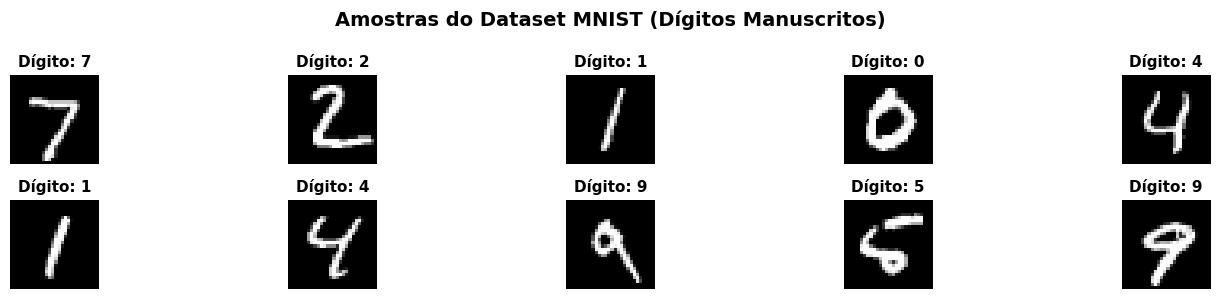

In [9]:
# Carregar dataset MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()

print(f" Dados carregados:")
print(f"• Training set: {x_train_mnist.shape}")
print(f"• Test set: {x_test_mnist.shape}")
print(f"• Classes: {np.unique(y_train_mnist)}")

# Normalizar valores de pixels para o intervalo [0, 1]
x_train_mnist = x_train_mnist.astype("float32") / 255.0
x_test_mnist = x_test_mnist.astype("float32") / 255.0

# Expandir dimensões para canal (grayscale)
x_train_mnist = np.expand_dims(x_train_mnist, -1)  # Shape: (60000, 28, 28, 1)
x_test_mnist = np.expand_dims(x_test_mnist, -1)    # Shape: (10000, 28, 28, 1)

print(f"   • X_train shape: {x_train_mnist.shape}")
print(f"   • X_test shape: {x_test_mnist.shape}")
print(f"   • y_train shape: {y_train_mnist.shape}")
print(f"   • y_test shape: {y_test_mnist.shape}")
print(f"   • Valores normalizados: [{x_train_mnist.min():.1f}, {x_train_mnist.max():.1f}]")

# Visualizar amostras do dataset
print(f"\n Visualizando amostras do dataset MNIST...")
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_mnist[i].reshape(28, 28), cmap='gray')
    plt.title(f'Dígito: {y_test_mnist[i]}', fontsize=11, fontweight='bold')
    plt.axis('off')
plt.suptitle('Amostras do Dataset MNIST (Dígitos Manuscritos)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**5.2) Construção do modelo vae para mnist**

In [10]:
# Construir encoder e decoder
encoder_mnist, decoder_mnist = build_vae(input_shape=(28, 28, 1), latent_dim=LATENT_DIM)

print("ARQUITETURA DO ENCODER:")
print("─" * 80)
encoder_mnist.summary()

print("\nARQUITETURA DO DECODER:")
print("─" * 80)
decoder_mnist.summary()

# Criar modelo VAE
vae_mnist = VAE(encoder_mnist, decoder_mnist)
vae_mnist.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))


ARQUITETURA DO ENCODER:
────────────────────────────────────────────────────────────────────────────────


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 14, 14,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 7, 7, 64)  │     18,496 │ conv1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_intermediate  │ (None, 128)       │    401,536 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 12)        │      1,548 │ dense_intermedia… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 12)        │      1,548 │ dense_intermedia… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 12)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,448 (1.62 MB)

 Trainable params: 423,448 (1.62 MB)

 Non-trainable params: 0 (0.00 B)


ARQUITETURA DO DECODER:
────────────────────────────────────────────────────────────────────────────────


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_decoder (Dense)           │ (None, 3136)           │        40,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv1 (Conv2DTranspose)       │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv2 (Conv2DTranspose)       │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,449 (376.75 KB)

 Trainable params: 96,449 (376.75 KB)

 Non-trainable params: 0 (0.00 B)

**5.3) Treinamento do vae - mnist**

In [11]:
print(f"• Épocas: {EPOCHS}")
print(f"• Batch size: {BATCH_SIZE}")
print(f"• Validação: {VALIDATION_SPLIT*100:.0f}% dos dados de treino")
print(f"• Dimensão latente: {LATENT_DIM}")
print(f"• Otimizador: Adam (lr=0.001)")
print("\n" + "─" * 80 + "\n")

# Treinar modelo
history_mnist = vae_mnist.fit(
    x_train_mnist, x_train_mnist,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    verbose=1
)


• Épocas: 50
• Batch size: 128
• Validação: 15% dos dados de treino
• Dimensão latente: 12
• Otimizador: Adam (lr=0.001)

────────────────────────────────────────────────────────────────────────────────

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - kl_loss: 7.0416 - loss: 252.8576 - reconstruction_loss: 245.8160 - val_kl_loss: 16.6976 - val_loss: 136.9478 - val_reconstruction_loss: 120.2502
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 18.0614 - loss: 126.1357 - reconstruction_loss: 108.0743 - val_kl_loss: 19.7990 - val_loss: 114.7083 - val_reconstruction_loss: 94.9093
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - kl_loss: 19.4209 - loss: 113.2461 - reconstruction_loss: 93.8252 - val_kl_loss: 20.1291 - val_loss: 111.2115 - val_reconstruction_loss: 91.0824
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 19.7338 - loss: 109.7530 - reconstruction_loss: 90.0191 - val_kl_loss: 20.4602 - val_loss: 109.6243 - val_reconstruction_loss: 89.1641


**5.4) Avaliação e visualização - mnist**

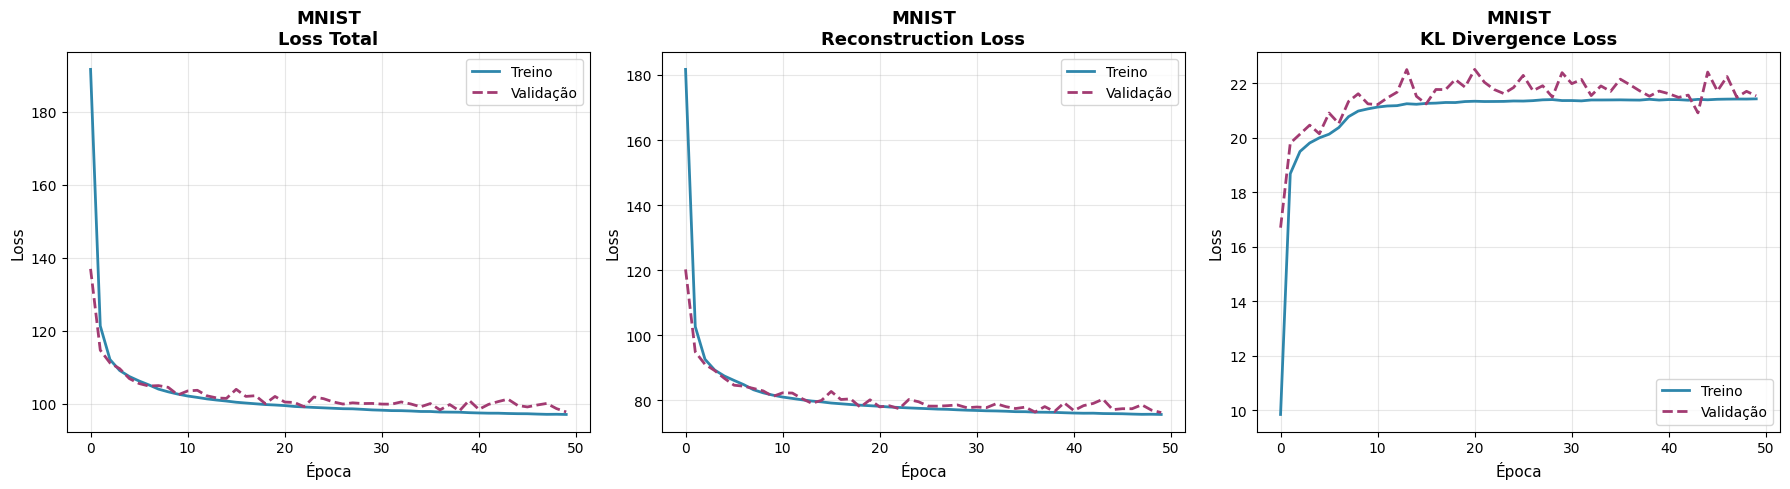


 AVALIAÇÃO NO CONJUNTO DE TESTE:
────────────────────────────────────────────────────────────────────────────────

   • Total Loss: 71.4846
   • Reconstruction Loss: 20.9188
   • KL Divergence: 92.4034
────────────────────────────────────────────────────────────────────────────────

 Visualizando reconstruções...


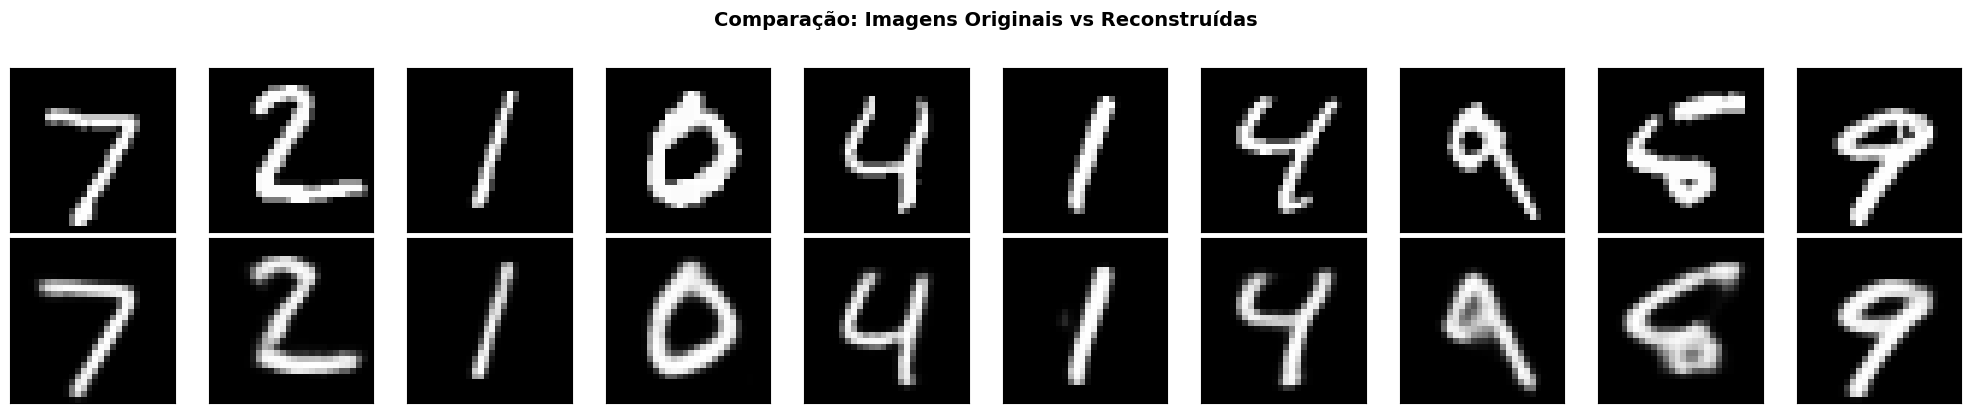

In [12]:
# Plotar histórico de treinamento
plot_training_history(history_mnist, "MNIST")

# Avaliar no test set
print("\n AVALIAÇÃO NO CONJUNTO DE TESTE:")
print("─" * 80)
test_results_mnist = vae_mnist.evaluate(x_test_mnist, x_test_mnist,
                                        batch_size=BATCH_SIZE, verbose=0)
print(f"\n   • Total Loss: {test_results_mnist[0]:.4f}")
print(f"   • Reconstruction Loss: {test_results_mnist[1]:.4f}")
print(f"   • KL Divergence: {test_results_mnist[2]:.4f}")
print("─" * 80)

# Visualizar reconstruções
print("\n Visualizando reconstruções...")
plot_reconstructions(vae_mnist, x_test_mnist, n=10)

**5.5) Análise do espaço latente - mnist**



  ANÁLISE DO ESPAÇO LATENTE - MNIST
   ✓ Shape do espaço latente: (10000, 12)

────────────────────────────────────────────────────────────────────────────────
   QUESTÃO 3: A projeção ilustra quanto da variância?
────────────────────────────────────────────────────────────────────────────────
      → Componente Principal 1 (PC1): 11.78%
      → Componente Principal 2 (PC2): 10.90%
      → VARIÂNCIA TOTAL EXPLICADA: 22.68%
────────────────────────────────────────────────────────────────────────────────

 Aplicando t-SNE (isso pode levar alguns segundos)...
   ✓ t-SNE completado com sucesso

 Gerando visualizações...


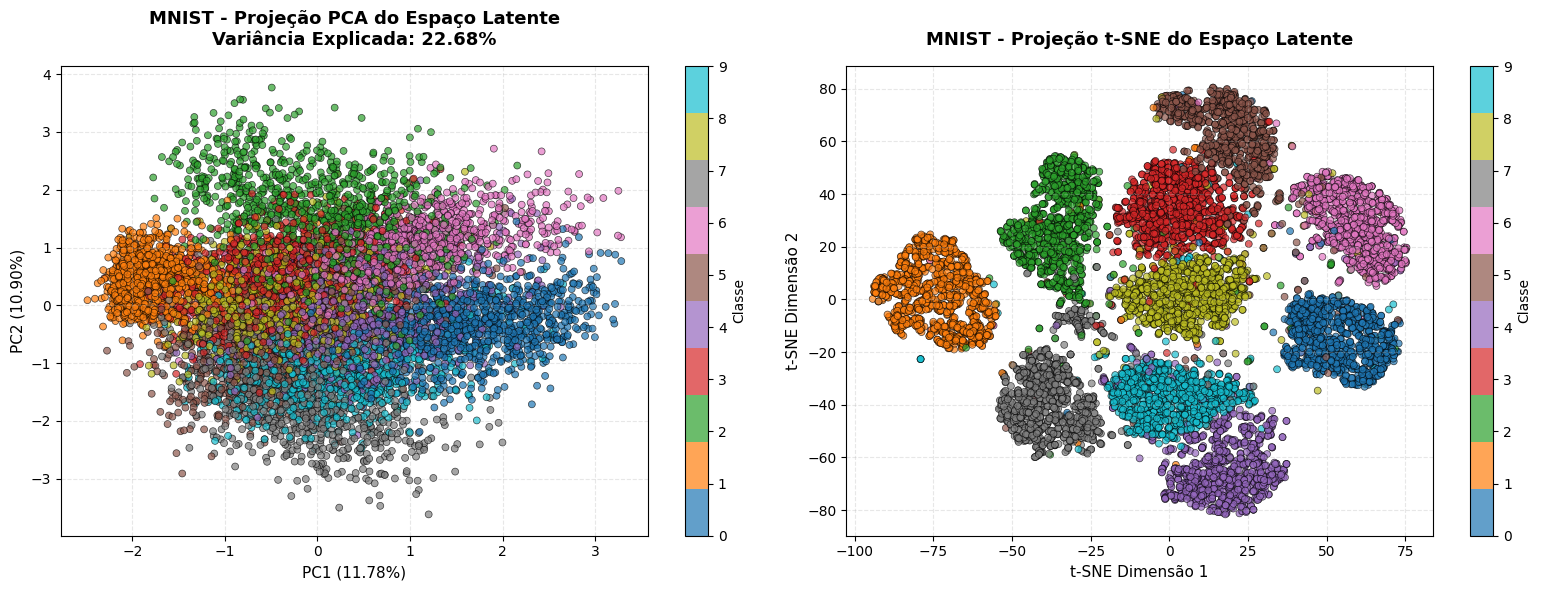


  ANÁLISE QUANTITATIVO - RESPOSTAS ÀS QUESTÕES

────────────────────────────────────────────────────────────────────────────────
  QUESTÃO 1: Há formação de clusters no espaço latente?
────────────────────────────────────────────────────────────────────────────────
Distância média entre centróides: 2.7851
Distância mínima: 1.6180
Distância máxima: 3.8332
Desvio padrão das distâncias: 0.4278

 SIM! Os clusters estão bem formados e consistentes.
         As classes ocupam regiões relativamente uniformes no espaço latente.
────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────
 QUESTÃO 2: Há separação dos rótulos no espaço latente?
────────────────────────────────────────────────────────────────────────────────
Variância intra-classe média: 7.1559
Variância inter-classe (dist. média): 2.7851
Razão inter/intra-classe: 0.39

      BAIXA separação entre classes.
         Há sobreposiç

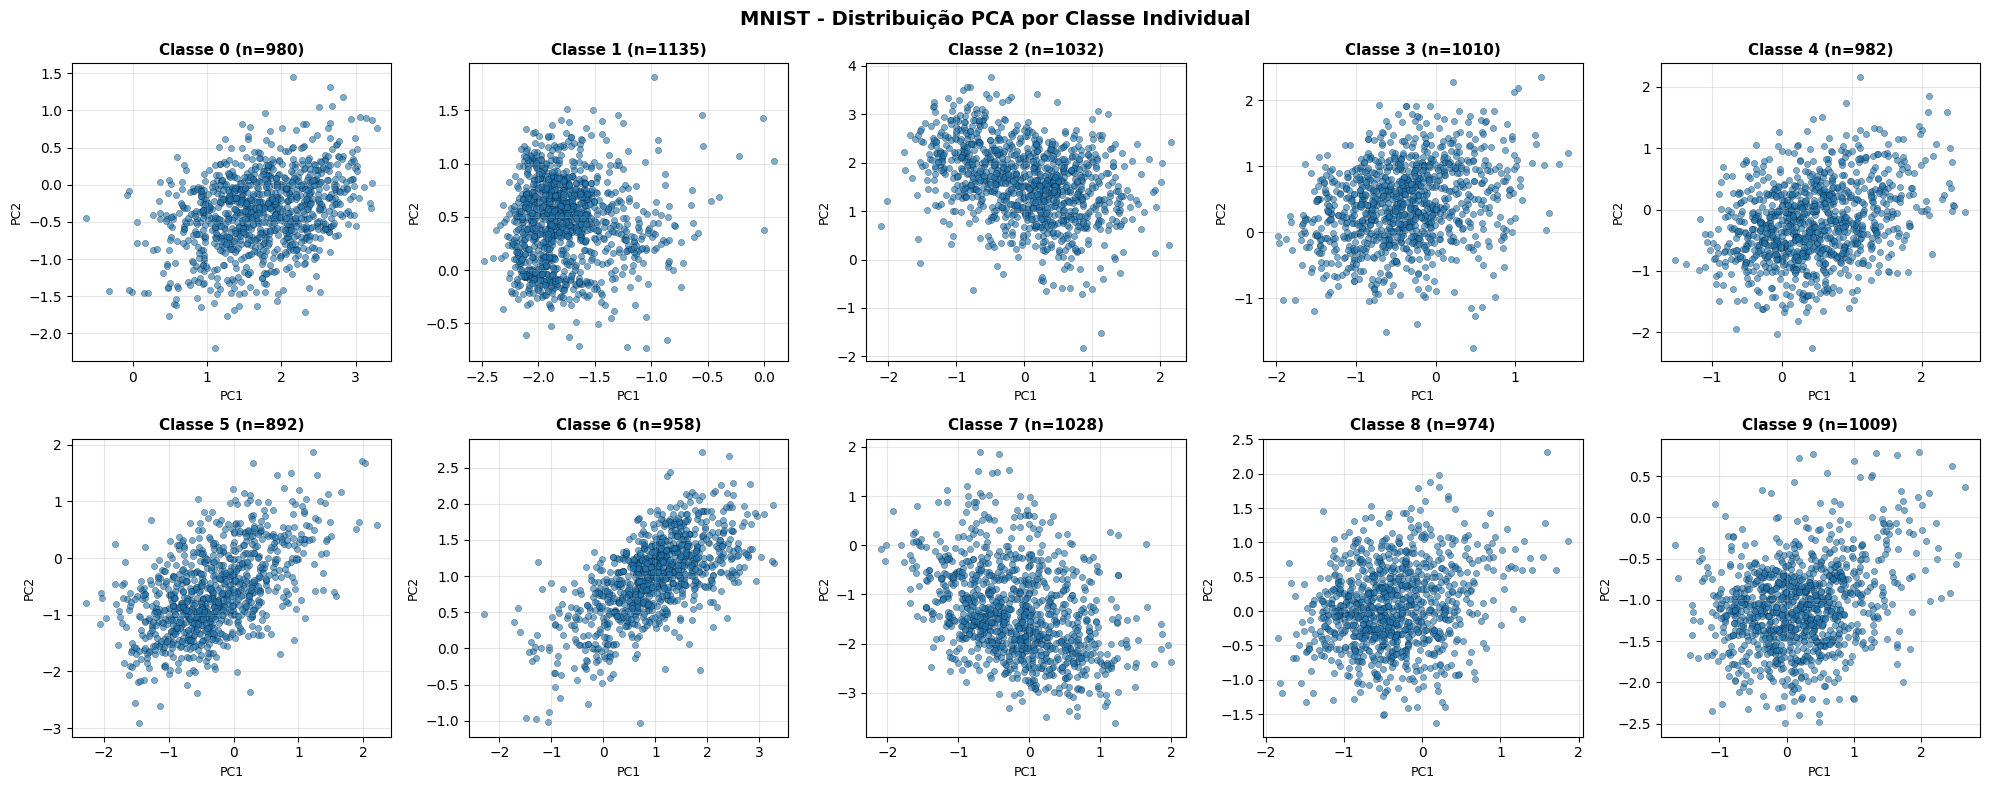

In [13]:
# Analisar espaço latente (responde às 3 questões do projeto)
x_pca_mnist, x_tsne_mnist, pca_mnist = analyze_latent_space(
    vae_mnist, x_test_mnist, y_test_mnist, "MNIST"
)

# 6) Dataset 2: Fashion-MNIST


**6.1) Carga e preparação dos dados**

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dados carregados:
• Training set: (60000, 28, 28)
• Test set: (10000, 28, 28)
• Classes: ['Camiseta/Top', 'Calça', 'Suéter', 'Vestido', 'Casaco', 'Sandália', 'Camisa', 'Tênis', 'Bolsa', 'Bota']
• X_train shape: (60000, 28, 28, 1)
• X_test shape: (10000, 28, 28, 1)
• y_train shape: (60000,)
• y_test shape: (10000,)
• Valores normalizados: [0.0, 1.0]

 Visualizando amostras do dataset Fashion-MNIST...


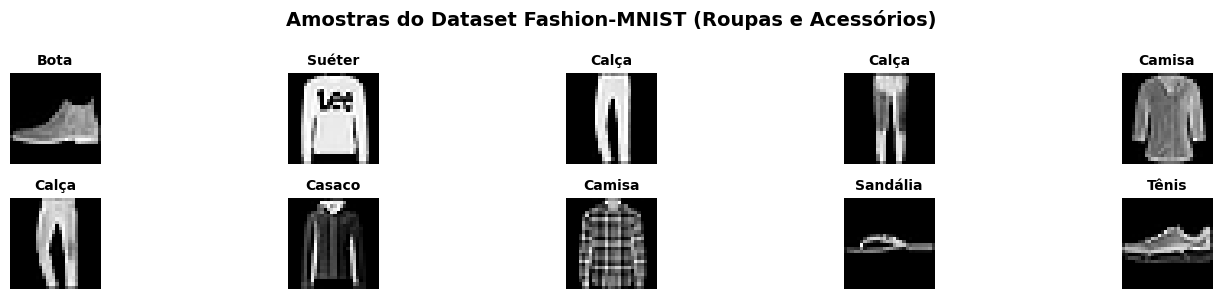

In [14]:
# Carregar dataset Fashion-MNIST
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = keras.datasets.fashion_mnist.load_data()

# Labels do Fashion-MNIST
fashion_labels = {
    0: 'Camiseta/Top',
    1: 'Calça',
    2: 'Suéter',
    3: 'Vestido',
    4: 'Casaco',
    5: 'Sandália',
    6: 'Camisa',
    7: 'Tênis',
    8: 'Bolsa',
    9: 'Bota'
}

print(f"Dados carregados:")
print(f"• Training set: {x_train_fashion.shape}")
print(f"• Test set: {x_test_fashion.shape}")
print(f"• Classes: {list(fashion_labels.values())}")

# Normalizar valores de pixels para o intervalo [0, 1]
x_train_fashion = x_train_fashion.astype("float32") / 255.0
x_test_fashion = x_test_fashion.astype("float32") / 255.0

# Expandir dimensões para canal (grayscale)
x_train_fashion = np.expand_dims(x_train_fashion, -1)
x_test_fashion = np.expand_dims(x_test_fashion, -1)

print(f"• X_train shape: {x_train_fashion.shape}")
print(f"• X_test shape: {x_test_fashion.shape}")
print(f"• y_train shape: {y_train_fashion.shape}")
print(f"• y_test shape: {y_test_fashion.shape}")
print(f"• Valores normalizados: [{x_train_fashion.min():.1f}, {x_train_fashion.max():.1f}]")

# Visualizar amostras do dataset
print(f"\n Visualizando amostras do dataset Fashion-MNIST...")
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_fashion[i].reshape(28, 28), cmap='gray')
    plt.title(f'{fashion_labels[y_test_fashion[i]]}', fontsize=10, fontweight='bold')
    plt.axis('off')
plt.suptitle('Amostras do Dataset Fashion-MNIST (Roupas e Acessórios)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**6.2) Construção do modelo vae para fashion-mnist**

In [15]:
# Construir encoder e decoder (mesma arquitetura que MNIST)
encoder_fashion, decoder_fashion = build_vae(input_shape=(28, 28, 1), latent_dim=LATENT_DIM)

print(" ARQUITETURA DO ENCODER:")
print("─" * 80)
encoder_fashion.summary()

print("\n ARQUITETURA DO DECODER:")
print("─" * 80)
decoder_fashion.summary()

# Criar modelo VAE
vae_fashion = VAE(encoder_fashion, decoder_fashion)
vae_fashion.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))


 ARQUITETURA DO ENCODER:
────────────────────────────────────────────────────────────────────────────────


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 14, 14,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 7, 7, 64)  │     18,496 │ conv1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_intermediate  │ (None, 128)       │    401,536 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 12)        │      1,548 │ dense_intermedia… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 12)        │      1,548 │ dense_intermedia… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 12)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,448 (1.62 MB)

 Trainable params: 423,448 (1.62 MB)

 Non-trainable params: 0 (0.00 B)


 ARQUITETURA DO DECODER:
────────────────────────────────────────────────────────────────────────────────


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_decoder (Dense)           │ (None, 3136)           │        40,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv1 (Conv2DTranspose)       │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv2 (Conv2DTranspose)       │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,449 (376.75 KB)

 Trainable params: 96,449 (376.75 KB)

 Non-trainable params: 0 (0.00 B)

**6.3) Treinamento do vae - fashion-mnist**

In [16]:
print(f"   • Épocas: {EPOCHS}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Validação: {VALIDATION_SPLIT*100:.0f}% dos dados de treino")
print(f"   • Dimensão latente: {LATENT_DIM}")
print(f"   • Otimizador: Adam (lr=0.001)")
print("\n" + "─" * 80 + "\n")

# Treinar modelo
history_fashion = vae_fashion.fit(
    x_train_fashion, x_train_fashion,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    verbose=1
)

   • Épocas: 50
   • Batch size: 128
   • Validação: 15% dos dados de treino
   • Dimensão latente: 12
   • Otimizador: Adam (lr=0.001)

────────────────────────────────────────────────────────────────────────────────

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - kl_loss: 7.8686 - loss: 370.1094 - reconstruction_loss: 362.2408 - val_kl_loss: 13.1182 - val_loss: 275.4739 - val_reconstruction_loss: 262.3557
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - kl_loss: 13.3233 - loss: 254.5582 - reconstruction_loss: 241.2348 - val_kl_loss: 13.7288 - val_loss: 266.0202 - val_reconstruction_loss: 252.2914
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 13.4683 - loss: 248.6562 - reconstruction_loss: 235.1879 - val_kl_loss: 13.4166 - val_loss: 262.7515 - val_reconstruction_loss: 249.3349
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 13.4609 - loss: 245.7226 - reconstruction_loss: 232.2617 - val_kl_loss: 13.6308 - val_loss: 260.6818 - val_reconstruc

**6.4) Avaliação e visualização - fashion-mnist**

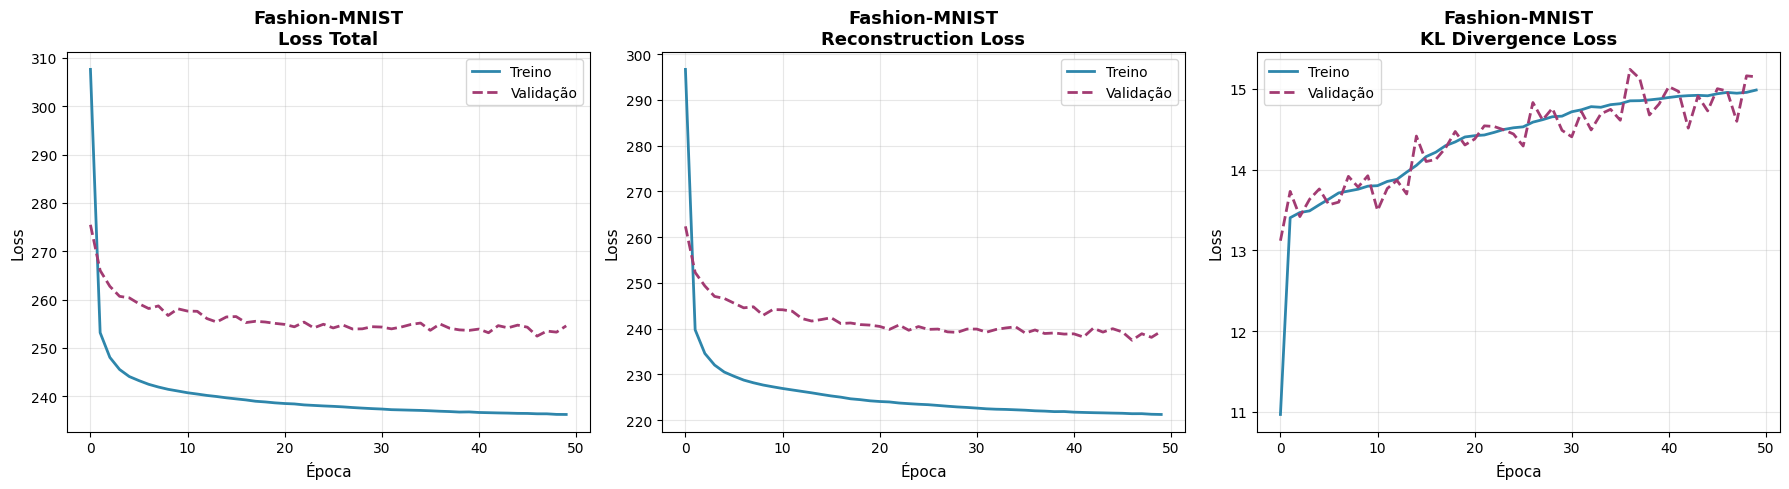


AVALIAÇÃO NO CONJUNTO DE TESTE:
────────────────────────────────────────────────────────────────────────────────

 • Total Loss: 211.0829
   • Reconstruction Loss: 15.3452
   • KL Divergence: 226.4281
────────────────────────────────────────────────────────────────────────────────

 Visualizando reconstruções...


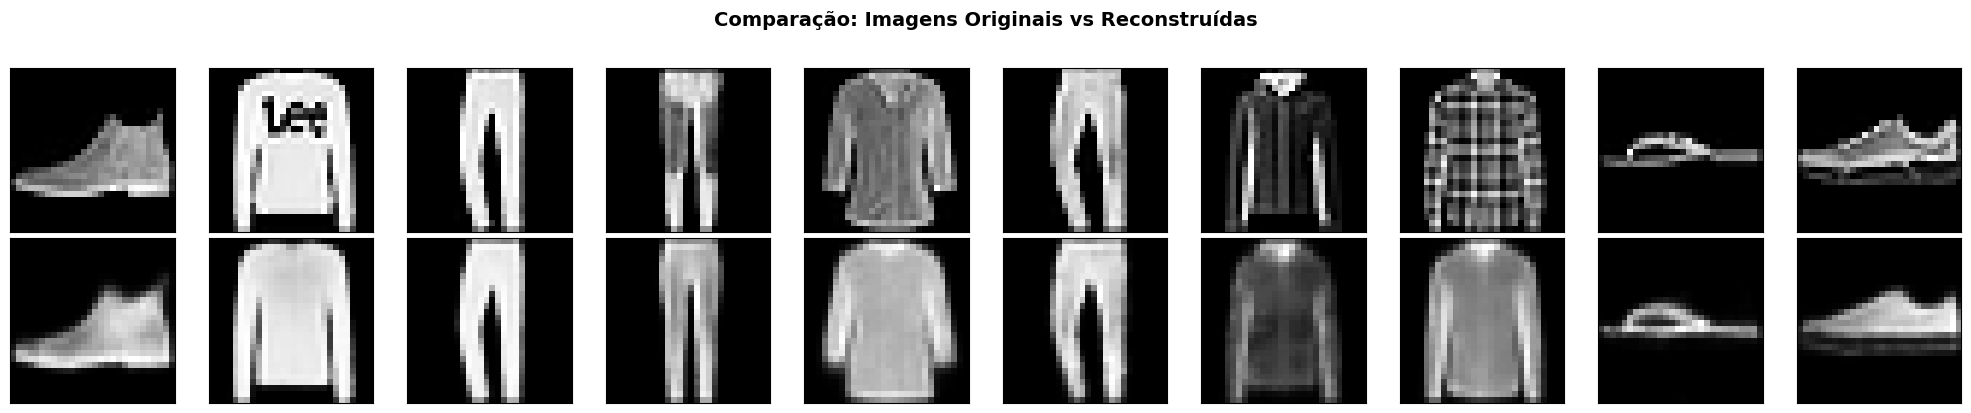

In [17]:

# Plotar histórico de treinamento
plot_training_history(history_fashion, "Fashion-MNIST")

# Avaliar no test set
print("\nAVALIAÇÃO NO CONJUNTO DE TESTE:")
print("─" * 80)
test_results_fashion = vae_fashion.evaluate(x_test_fashion, x_test_fashion,
                                            batch_size=BATCH_SIZE, verbose=0)
print(f"\n • Total Loss: {test_results_fashion[0]:.4f}")
print(f"   • Reconstruction Loss: {test_results_fashion[1]:.4f}")
print(f"   • KL Divergence: {test_results_fashion[2]:.4f}")
print("─" * 80)

# Visualizar reconstruções
print("\n Visualizando reconstruções...")
plot_reconstructions(vae_fashion, x_test_fashion, n=10)

**6.5) Análise do espaço latente - fashion-mnist**


  ANÁLISE DO ESPAÇO LATENTE - Fashion-MNIST
   ✓ Shape do espaço latente: (10000, 12)

────────────────────────────────────────────────────────────────────────────────
   QUESTÃO 3: A projeção ilustra quanto da variância?
────────────────────────────────────────────────────────────────────────────────
      → Componente Principal 1 (PC1): 15.56%
      → Componente Principal 2 (PC2): 15.00%
      → VARIÂNCIA TOTAL EXPLICADA: 30.56%
────────────────────────────────────────────────────────────────────────────────

 Aplicando t-SNE (isso pode levar alguns segundos)...
   ✓ t-SNE completado com sucesso

 Gerando visualizações...


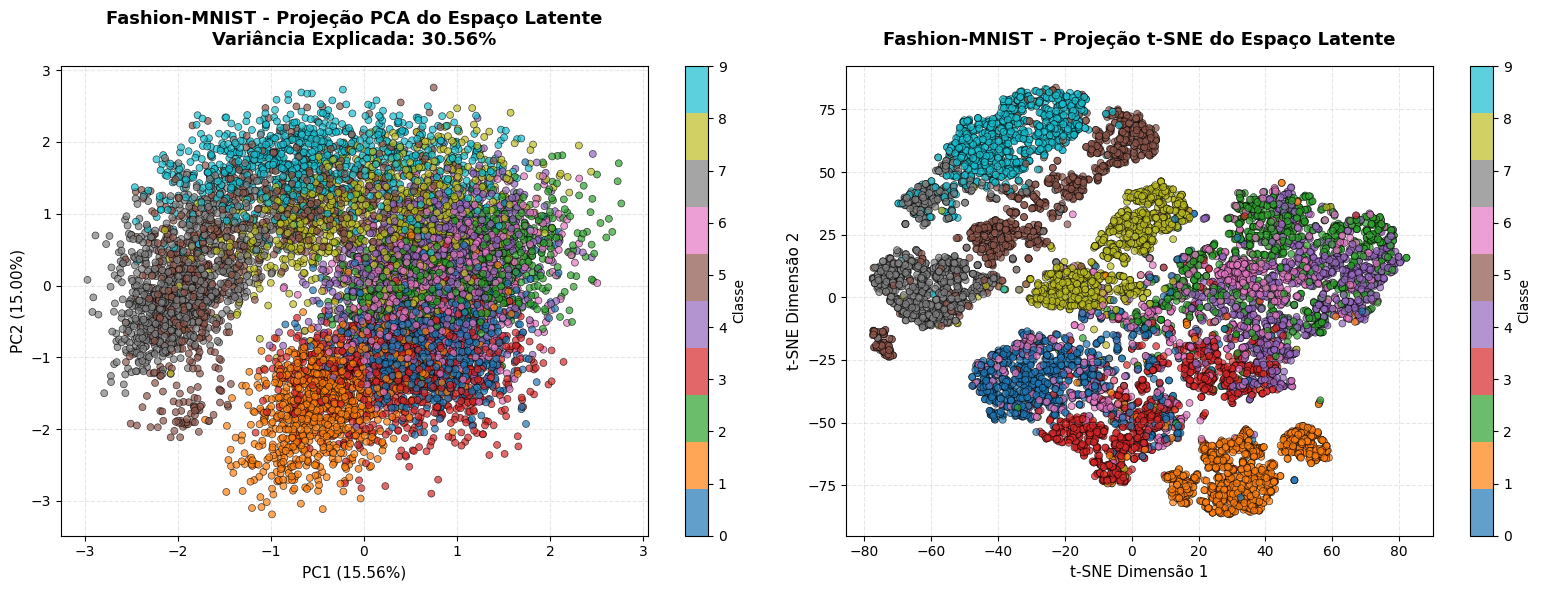


  ANÁLISE QUANTITATIVO - RESPOSTAS ÀS QUESTÕES

────────────────────────────────────────────────────────────────────────────────
  QUESTÃO 1: Há formação de clusters no espaço latente?
────────────────────────────────────────────────────────────────────────────────
Distância média entre centróides: 2.5163
Distância mínima: 1.0773
Distância máxima: 3.5290
Desvio padrão das distâncias: 0.5710

 SIM! Os clusters estão bem formados e consistentes.
         As classes ocupam regiões relativamente uniformes no espaço latente.
────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────
 QUESTÃO 2: Há separação dos rótulos no espaço latente?
────────────────────────────────────────────────────────────────────────────────
Variância intra-classe média: 5.1471
Variância inter-classe (dist. média): 2.5163
Razão inter/intra-classe: 0.49

      BAIXA separação entre classes.
         Há sobreposiç

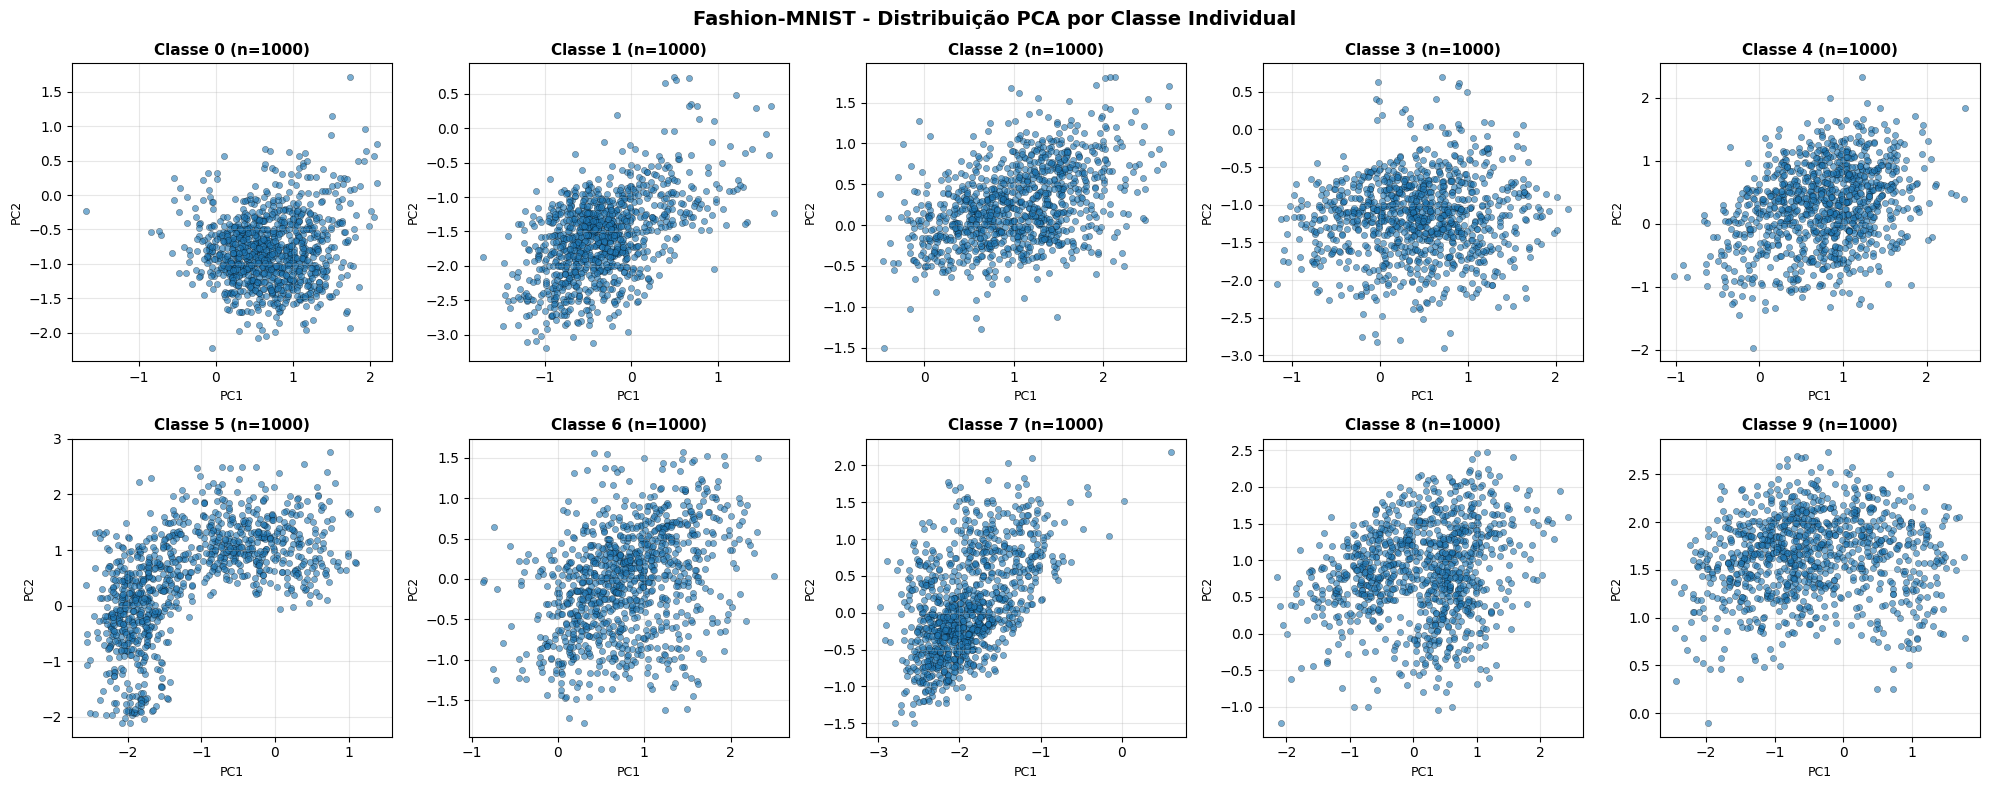

In [18]:
# Analisar espaço latente (responde às 3 questões do projeto)
x_pca_fashion, x_tsne_fashion, pca_fashion = analyze_latent_space(
    vae_fashion, x_test_fashion, y_test_fashion, "Fashion-MNIST"
)

#7) Comparação Final


# 8) Conclusões


# 9) Referências

#Observacion sobre espacio latente

- a dimension do espacio latente nao necessariamente precisa ser menor que a dimension original
- dofemos usar autoencoders esparsos para ampliar a domencionalidade de representacion do problema
- os autoencoders esparsos demandam algun tipo de regularizacion para evitar o aprendizado da solucion trivial